In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = tf.transpose(x_train,[1,2,0])
x_test = tf.transpose(x_test,[1,2,0])
x_train = tf.image.resize(x_train,[32,32])
x_test = tf.image.resize(x_test,[32,32])
x_train = tf.transpose(x_train,[2,0,1])
x_test = tf.transpose(x_test,[2,0,1])
input_shape = [32,32,1]
model = models.Sequential()
Conv2D = layers.Conv2D
MaxPooling2D = layers.MaxPooling2D
Flatten = layers.Flatten
Dense = layers.Dense
Dropout = layers.Dropout
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides = (2, 2))) 
model.add(Flatten()) 
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
sgd = tf.keras.optimizers.SGD(learning_rate=0.1,momentum=0.9, nesterov=True)
model.compile(optimizer='sgd',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
1875/1875 [==============================] - 40s 20ms/step - loss: 2.2939 - accuracy: 0.1265 - val_loss: 2.2556 - val_accuracy: 0.2653
Epoch 2/3
1875/1875 [==============================] - 37s 20ms/step - loss: 0.9283 - accuracy: 0.6853 - val_loss: 0.1698 - val_accuracy: 0.9465
Epoch 3/3
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1406 - accuracy: 0.9558 - val_loss: 0.0810 - val_accuracy: 0.9744


In [2]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
def FGSM(model, x, y, eps):
    x = x.reshape(1, 32, 32, 1)
    with tf.GradientTape() as tape:
        tape.watch(x)
        pred = model(x)
        loss = SparseCategoricalCrossentropy(from_logits=False)(y, pred)
    gradient = tape.gradient(loss, x)
    signedg = tf.sign(gradient)
    adversary = (x + (signedg * eps)).numpy()
    return adversary    

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
eps = [0.2,0.1,0.5]
test_FGSM = [[] for i in range(len(eps))]
for j in range(len(eps)):
    for i in range(len(y_test)):
        x_adv = FGSM(model,x_test[i],y_test[i],eps[j])
        x_adv = x_adv.reshape(32, 32, 1)
        test_FGSM[j].append(x_adv)
    loss, test_acc = model.evaluate(np.array(test_FGSM[j]), y_test, verbose=1)
    print('The accuracy before adversarial training for FGSM input with eps = ',eps[j], 'is ',test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 5.9383 - accuracy: 0.0606
The accuracy before adversarial training for FGSM input with eps =  0.2 is  0.060600001364946365
313/313 [==============================] - 2s 7ms/step - loss: 1.9555 - accuracy: 0.5339
The accuracy before adversarial training for FGSM input with eps =  0.1 is  0.5339000225067139
313/313 [==============================] - 2s 7ms/step - loss: 11.3864 - accuracy: 5.0000e-04
The accuracy before adversarial training for FGSM input with eps =  0.5 is  0.0005000000237487257


Original Image
epsilon = 0.200000
epsilon = 0.100000
epsilon = 0.500000


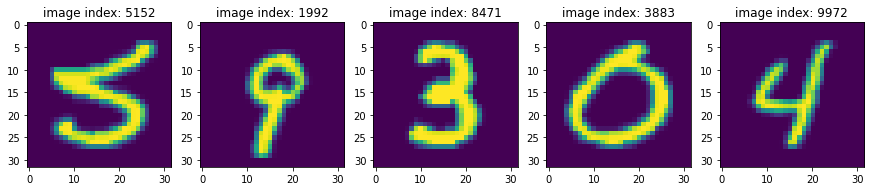

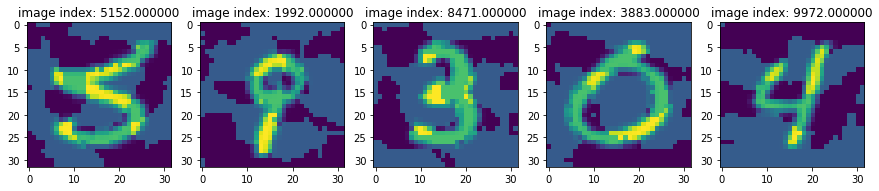

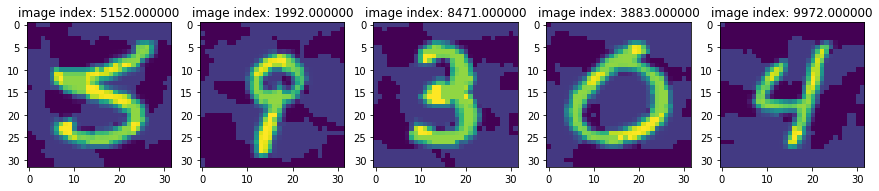

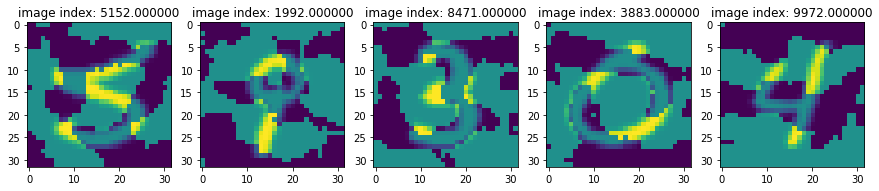

In [4]:
import matplotlib.pyplot as plt
index = np.random.randint(0,len(x_test),size=5)
print('Original Image')
fig = plt.figure(figsize = (15,15))
for i in range(len(index)):
    ax = fig.add_subplot(1,5,i+1)
    ax.set_title('image index: %d'%(index[i]))
    plt.imshow(x_test[index[i]])
for i in range(3):
    print('epsilon = %f'%(eps[i]))
    fig = plt.figure(figsize = (15,15))
    for j in range(len(index)):
        ax = fig.add_subplot(1,5,j+1)
        ax.set_title('image index: %f'%(index[j]))
        plt.imshow(test_FGSM[i][index[j]].squeeze())

In [5]:
train_FGSM = []
for i in range(len(x_train)):
    x_adv1 = FGSM(model,x_train[i],y_train[i],0.5)
    x_adv1 = x_adv1.reshape(32, 32, 1)
    train_FGSM.append(x_adv1)
new_model = tf.keras.models.clone_model(model)
new_model.compile(optimizer='sgd',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
history = new_model.fit(np.array(train_FGSM), y_train, epochs=3, validation_split = 0.2, verbose=1)
loss, test_acc = new_model.evaluate(x_test, y_test, verbose=1)
print('The accuracy after FGSM training is ',test_acc)
for j in range(len(eps)):
    loss, test_acc = new_model.evaluate(np.array(test_FGSM[j]), y_test, verbose=1)
    print('The test accuracy after FGSM training with eps = ',eps[j], 'is ',test_acc)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1500/1500 [==============================] - 31s 20ms/step - loss: 2.2991 - accuracy: 0.1138 - val_loss: 2.2945 - val_accuracy: 0.1060
Epoch 2/3
1500/1500 [==============================] - 30s 20ms/step - loss: 1.9086 - accuracy: 0.3163 - val_loss: 0.5186 - val_accuracy: 0.8223
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 3.5085 - accuracy: 0.0487
The accuracy after FGSM training is  0.048700001090765
313/313 [==============================] - 2s 7ms/step - loss: 0.3350 - accuracy: 0.8822
The test accuracy after FGSM training with eps =  0.2 is  0.8822000026702881
313/313 [==============================] - 2s 7ms/step - loss: 1.2461 - accuracy: 0.5820
The test accuracy after FGSM training with eps =  0.1 is  0.5820000171661377
313/313 [==============================] - 2s 7ms/step - loss: 0.0546 - accuracy: 0.9813
The test accuracy after FGSM training with eps =  0.5 is  0.9812999963760376


In [6]:
def PGD(model, x, y, eps,rate):
    x = x.reshape(1, 32, 32, 1)
    x_origin = x
    max_iter = 10
    for ite in range(max_iter):
        x_last = x
        with tf.GradientTape() as tape:
            tape.watch(x)
            pred = model(x)
            loss = SparseCategoricalCrossentropy(from_logits=False)(y, pred)
        gradient = tape.gradient(loss, x)
        signedg = tf.sign(gradient)
        x = x + (rate*signedg)
        x = tf.clip_by_value(x, x_origin-eps, x_origin+eps)
        if np.sum(np.abs((x - x_last).numpy()))/np.sum(np.abs((x.numpy()))) <= 1e-1:
            break
    adversary = x.numpy()
    return adversary

In [10]:
test_PGD = [[] for i in range(len(eps))]
learning_rate = 0.4
for j in range(len(eps)):
    for i in range(len(y_test)):
        x_adv2 = PGD(model,x_test[i],y_test[i],eps[j],learning_rate)
        x_adv2 = x_adv2.reshape(32, 32, 1)
        test_PGD[j].append(x_adv2)
    loss, test_acc = model.evaluate(np.array(test_PGD[j]), y_test, verbose=1)
    print('The accuracy before adversarial training for PGD input with eps = ',eps[j], 'is ',test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 6.7724 - accuracy: 0.0331
The accuracy before adversarial training for PGD input with eps =  0.2 is  0.03310000151395798
313/313 [==============================] - 2s 7ms/step - loss: 2.2467 - accuracy: 0.4647
The accuracy before adversarial training for PGD input with eps =  0.1 is  0.46470001339912415
313/313 [==============================] - 2s 7ms/step - loss: 21.3345 - accuracy: 0.0000e+00
The accuracy before adversarial training for PGD input with eps =  0.5 is  0.0


epsilon = 0.200000
epsilon = 0.100000
epsilon = 0.500000


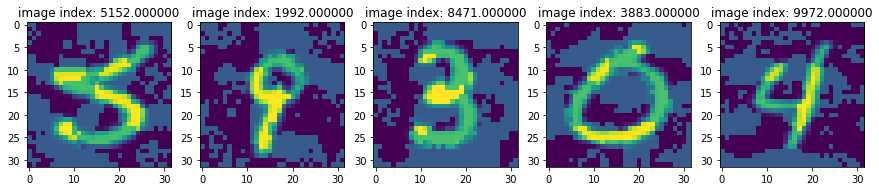

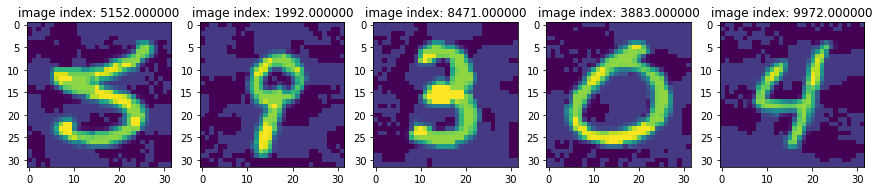

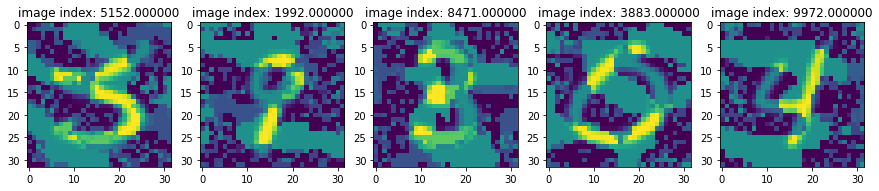

In [11]:
for i in range(3):
    print('epsilon = %f'%(eps[i]))
    fig = plt.figure(figsize = (15,15))
    for j in range(len(index)):
        ax = fig.add_subplot(1,5,j+1)
        ax.set_title('image index: %f'%(index[j]))
        plt.imshow(test_PGD[i][index[j]].squeeze())

In [15]:
train_PGD = []
for i in range(len(x_train)):
    x_adv = PGD(model,x_train[i],y_train[i],0.5,learning_rate)
    x_adv = x_adv.reshape(32, 32, 1)
    train_PGD.append(x_adv)
new_model_1 = tf.keras.models.clone_model(model)
new_model_1.compile(optimizer='sgd',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
history = new_model_1.fit(np.array(train_PGD), y_train, epochs=3, validation_split = 0.2, verbose=1)
loss, test_acc = new_model_1.evaluate(x_test, y_test, verbose=1)
print('The accuracy after PGD training is ',test_acc)
for j in range(len(eps)):
    loss, test_acc = new_model_1.evaluate(np.array(test_PGD[j]), y_test, verbose=1)
    print('The test accuracy after PGD training with eps = ',eps[j], 'is ',test_acc)

Epoch 1/3
1500/1500 [==============================] - 31s 20ms/step - loss: 2.3000 - accuracy: 0.1132 - val_loss: 2.2981 - val_accuracy: 0.1060
Epoch 2/3
1500/1500 [==============================] - 30s 20ms/step - loss: 2.2718 - accuracy: 0.1551 - val_loss: 2.0325 - val_accuracy: 0.3365
Epoch 3/3
313/313 [==============================] - 2s 7ms/step - loss: 1.8028 - accuracy: 0.3883
The accuracy after PGD training is  0.38830000162124634
313/313 [==============================] - 2s 7ms/step - loss: 0.7281 - accuracy: 0.7607
The test accuracy after PGD training with eps =  0.2 is  0.760699987411499
313/313 [==============================] - 2s 7ms/step - loss: 1.0230 - accuracy: 0.6623
The test accuracy after PGD training with eps =  0.1 is  0.6622999906539917
313/313 [==============================] - 2s 7ms/step - loss: 0.2932 - accuracy: 0.9077
The test accuracy after PGD training with eps =  0.5 is  0.9077000021934509


In [16]:
#PGD trained model vs FGSM attack
for j in range(len(eps)):
    loss, test_acc = new_model_1.evaluate(np.array(test_FGSM[j]), y_test, verbose=1)
    print('The FGSM attack test accuracy after PGD training with eps = ',eps[j], 'is ',test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 0.7446 - accuracy: 0.7610
The FGSM attack test accuracy after PGD training with eps =  0.2 is  0.7609999775886536
313/313 [==============================] - 2s 7ms/step - loss: 0.9796 - accuracy: 0.6759
The FGSM attack test accuracy after PGD training with eps =  0.1 is  0.6758999824523926
313/313 [==============================] - 2s 7ms/step - loss: 1.1858 - accuracy: 0.5930
The FGSM attack test accuracy after PGD training with eps =  0.5 is  0.5929999947547913


In [17]:
#FGSM trained model vs PGD attack
for j in range(len(eps)):
    loss, test_acc = new_model.evaluate(np.array(test_PGD[j]), y_test, verbose=1)
    print('The PGD attack test accuracy after FGSM training with eps = ',eps[j], 'is ',test_acc)

313/313 [==============================] - 2s 7ms/step - loss: 2.1693 - accuracy: 0.3577
The PGD attack test accuracy after FGSM training with eps =  0.2 is  0.357699990272522
313/313 [==============================] - 2s 7ms/step - loss: 2.0390 - accuracy: 0.3249
The PGD attack test accuracy after FGSM training with eps =  0.1 is  0.3249000012874603
313/313 [==============================] - 2s 7ms/step - loss: 2.6189 - accuracy: 0.3985
The PGD attack test accuracy after FGSM training with eps =  0.5 is  0.398499995470047
